Proyecto final: Weather prediction

Por:

*   María Fonseca
*   Rafael villero



In [ ]:
# Carga del dataset
import pandas as pd
df = pd.read_csv('seattle-weather.csv')

In [ ]:
# Primeras cinco líneas del dataset
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [ ]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           1461 non-null   object 
 1   precipitation  1461 non-null   float64
 2   temp_max       1461 non-null   float64
 3   temp_min       1461 non-null   float64
 4   wind           1461 non-null   float64
 5   weather        1461 non-null   object 
dtypes: float64(4), object(2)
memory usage: 68.6+ KB


In [ ]:
# Balance de clases de la variable objetivo
df['weather'].value_counts()

,count
weather,
rain,641
sun,640
fog,101
drizzle,53
snow,26


In [ ]:
# Detección de valores unicos
df.nunique().sort_values()

,0
weather,5
temp_min,55
temp_max,67
wind,79
precipitation,111
date,1461


In [ ]:
# Detección de valores faltantes
df.isna().sum().sort_values(ascending=False)

,0
date,0
precipitation,0
temp_max,0
temp_min,0
wind,0
weather,0


In [ ]:
#Eliminación de columna innecesaria: DATE
X = df.drop(["weather", "date"], axis=1)
y = df["weather"]

GRADIENT BOOSTERING.

Es una técnica de aprendizaje supervisado que combina muchos modelos débiles (generalmente árboles de decisión pequeños) para crear un modelo muy fuerte.



In [ ]:
#Instalación
!pip install xgboost imbalanced-learn

In [ ]:
#Importanción de librerías
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

Para asegurar que el modelo tenga un desempeño óptimo se realizó una conversión de las categorías de la variable objeto, de valores tipo cadena a entero. Estableciento un número específico para cada una.

In [ ]:
# Preparación de datos.
# Se utilizó un diccionario llamado mapping que reemplazará cada
# valor textual por los números seleccionados.
mapping = {
    "sun": 0,
    "rain": 1,
    "drizzle": 2,
    "snow": 3,
    "fog": 4
}

# Se re define weather_encoded como la nueva variable objetivo
df["weather_encoded"] = df["weather"].map(mapping)

In [ ]:
# Se definen X y Y
X = df[["precipitation", "temp_max", "temp_min", "wind"]]
y = df["weather_encoded"]

Se divide el dataset en dos conjuntos.

El primer conjunto, con un 70% de la cantidad total de registros, se destina como conjunto de entrenamiento para el modelo, y el segundo conjunto con el 30% de los registros totales se destina a probar el desempeño del modelo.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)

In [ ]:
# Estandarizar las features
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Para contrarrestar el desbalance del dataset se realiza un balanceo de clases con SMOTE. Donde todas las clases tienen igual número de muestras, permiento al modelo aprender a detectar mejor las categorías con menor número de registros: Drizzle, snow y fog.

In [ ]:
sm = SMOTE(random_state=42)
X_train_bal, y_train_bal = sm.fit_resample(X_train_scaled, y_train)

Entrenamiento del modelo Gradient Boosting (XGBoot)

In [ ]:
model = XGBClassifier(
    objective="multi:softprob",
    num_class=5,
    eval_metric="mlogloss",
    n_estimators=300,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

model.fit(X_train_bal, y_train_bal)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None, num_class=5, ...)

In [ ]:
# Predicciones
y_pred = model.predict(X_test_scaled)

In [ ]:
# Resumen de resultados de métricas de desempeño
print(classification_report(y_test, y_pred, digits=2))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81       192
           1       0.95      0.91      0.93       193
           2       0.14      0.19      0.16        16
           3       0.27      0.38      0.32         8
           4       0.27      0.27      0.27        30

    accuracy                           0.79       439
   macro avg       0.49      0.51      0.50       439
weighted avg       0.80      0.79      0.79       439



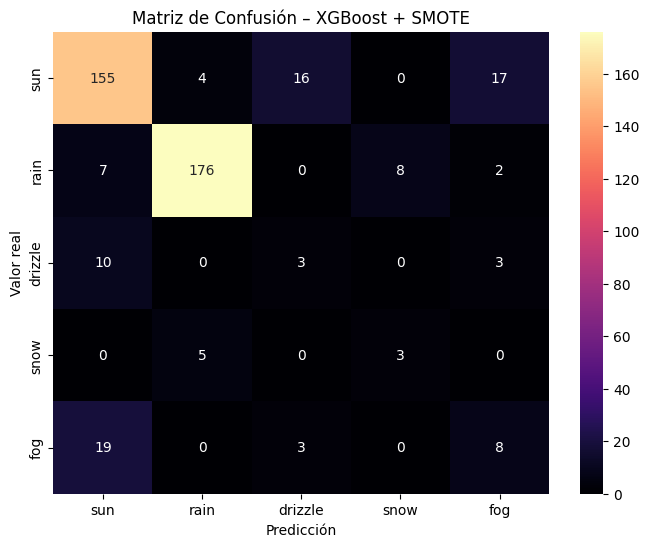

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="magma",
            xticklabels=mapping.keys(),
            yticklabels=mapping.keys())
plt.xlabel("Predicción")
plt.ylabel("Valor real")
plt.title("Matriz de Confusión – XGBoost + SMOTE")
plt.show()
